In [1]:
import tensorflow as tf
import os
import cv2
import pandas as pd
import random

from assets.evaluation.data_generator_fullmask import DR_Generator
from assets.one_mask.models import SMD_Unet 
from assets.one_mask.trainer import Trainer

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'assets.evaluation'

In [ ]:
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/FGADR/Seg-set'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

generator_args = {
    'dir_path':'../data/FGADR/Seg-set/Original_Images/',
    'mask_path':mask_paths,
    'use_mask':True,
    'img_size':(512, 512),  
    'batch_size':4, # 8로 하면 바로 OOM 뜸
    'dataset':'FGADR', # FGADR or EyePacks
    'use_3channel':True, # 3채널 모델을 사용할 때는 True로 바꿔야함
    'CLAHE_args':None
}

tr_fgadr_gen = DR_Generator(start_end_index=(0, 1292), is_train=True, **generator_args)
val_fgadr_gen = DR_Generator(start_end_index=(1292, 1476), is_train=False, **generator_args)
ts_fgadr_gen = DR_Generator(start_end_index=(1476, 1842), is_train=False, **generator_args)

# tr_fgadr_gen = DR_Generator(start_end_index=(0, 30000), is_train=True, **generator_args)
# val_fgadr_gen = DR_Generator(start_end_index=(30000, 31000), is_train=False, **generator_args)

In [ ]:
model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3) # 3채널 모델을 사용할 때는 3으로

In [ ]:
# 채널 1개
#model.load_weights("../models/one_mask/withoutCLAHE_withoutRecons_alpha00_lr00001/1")

# 채널 3개
model.load_weights("../models/one_mask/withoutCLAHE_withRecons_pretraining_3ch_alpha01_lr00001/49")

In [31]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)  # 교집합 계산
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)  # 합집합 계산
    return (2. * intersection + smooth) / (union + smooth)

def mean_absolute_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))  # MAE 계산

def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)  # 예측값 이진화
    intersection = tf.reduce_sum(y_true * y_pred)  # 교집합 계산
    union = tf.reduce_sum(tf.cast(y_true + y_pred > threshold, tf.float32))  # 합집합 계산
    return intersection / (union + 1e-7)  # IoU 계산, 1e-7 추가로 나눗셈 by zero 방지

In [32]:
# 세그멘테이션 결과를 평가하는 함수
# y_true와 y_pred는 [batch_size, height, width, channels] 형식으로 가정
def evaluate_segmentation(y_true, y_pred):
    # 배열을 평평하게 만든다.
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Dice 계수 계산
    dice = dice_coefficient(y_true_flat, y_pred_flat)

    # IoU (Intersection over Union) 계산
    iou = calculate_iou(y_true_flat, y_pred_flat)

    # AUC-ROC 계산
    roc_auc = roc_auc_score(y_true_flat, y_pred_flat)

    # AUC-PR 계산
    pr_auc = average_precision_score(y_true_flat, y_pred_flat)

    # MAE 계산
    mae = mean_absolute_error(y_true_flat, y_pred_flat)

    return dice, iou, roc_auc, pr_auc, mae

In [ ]:
for inputs, ex, he, ma, se, targets, pathlist in tr_fgadr_gen:
    break

preds = model(inputs[0])

In [ ]:
def apply_color_to_mask(mask, color):
    # 마스크의 흰색 영역을 해당 색으로 변경
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    colored_mask[mask == 1] = color
    return colored_mask

def combine_masks(mask_ex, mask_he, mask_ma, mask_se):
    # 각 마스크를 색상으로 변환
    mask_ex_color = apply_color_to_mask(tf.squeeze(mask_ex), [255, 0, 0])  # 빨간색
    mask_he_color = apply_color_to_mask(tf.squeeze(mask_he), [0, 0, 255])  # 파란색
    mask_ma_color = apply_color_to_mask(tf.squeeze(mask_ma), [255, 255, 0])  # 노란색
    mask_se_color = apply_color_to_mask(tf.squeeze(mask_se), [0, 255, 0])  # 초록색

    # 색상별 마스크를 합치기
    combined_mask = mask_ex_color + mask_he_color + mask_ma_color + mask_se_color
    combined_mask[combined_mask > 255] = 255  # 최대값을 255로 제한
    return combined_mask

def visualize_segmentation(image, mask_ex, mask_he, mask_ma, mask_se, mask_true, mask_pred):
    plt.figure(figsize=(18, 12))

    # 원본 이미지 및 각 마스크
    plt.subplot(2, 5, 1)    
    image_np = tf.squeeze(inputs[0][i]).numpy()
    img_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Ex 마스크 출력 (빨간색)
    plt.subplot(2, 5, 2)
    mask_ex_color = apply_color_to_mask(tf.squeeze(mask_ex), [255, 0, 0])  # 빨간색
    print(mask_ex_color)
    plt.imshow(mask_ex_color)
    plt.title('Ex Mask')
    plt.axis('off')

    # He 마스크 출력 (파란색)
    plt.subplot(2, 5, 3)
    mask_he_color = apply_color_to_mask(tf.squeeze(mask_he), [0, 0, 255])  # 파란색
    print(mask_he_color)
    plt.imshow(mask_he_color)
    plt.title('He Mask')
    plt.axis('off')

    # Ma 마스크 출력 (노란색)
    plt.subplot(2, 5, 4)
    mask_ma_color = apply_color_to_mask(tf.squeeze(mask_ma), [255, 255, 0])  # 노란색
    print(mask_he_color)
    plt.imshow(mask_ma_color)
    plt.title('Ma Mask')
    plt.axis('off')

    # Se 마스크 출력 (초록색)
    plt.subplot(2, 5, 5)
    mask_se_color = apply_color_to_mask(tf.squeeze(mask_se), [0, 255, 0])  # 초록색
    print(mask_he_color)
    plt.imshow(mask_se_color)
    plt.title('Se Mask')
    plt.axis('off')

    plt.tight_layout()

    # Target 및 Predicted 마스크
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # 실제 세그멘테이션 마스크 출력 (Target 마스크)
    mask_target_combined = combine_masks(mask_ex, mask_he, mask_ma, mask_se)
    print(mask_target_combined)
    axes[0].imshow(mask_target_combined)
    axes[0].set_title('Target Mask')
    axes[0].axis('off')

    # 예측된 세그멘테이션 마스크 출력
    axes[1].imshow(tf.squeeze(mask_pred), cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# 이미지 개수
num_images = len(inputs[0])
print(num_images)

# 랜덤하게 5개의 인덱스 선택
random_indices = random.sample(range(num_images), num_images)

# 선택된 인덱스에 대해 이미지 및 해당 이미지의 평가 지표 출력
for i in random_indices:
    
    # 세그멘테이션 평가
    dice, iou, roc_auc, pr_auc, mae = evaluate_segmentation(targets[i], preds[1][i])

    # 이미지 및 마스크 시각화
    visualize_segmentation(inputs[0][i], ex[i], he[i], ma[i], se[i], targets[i], preds[1][i])

    # 평가 지표 출력
    file_name = os.path.basename(pathlist[i])
    print(f"Image Evaluation Metrics: {file_name}")
    print("Dice Coefficient: {:.2f}\t\t".format(dice.numpy()), end="")
    print("IoU: {:.2f}\t".format(iou.numpy()), end="")
    print("ROC AUC Score: {:.2f}\t".format(roc_auc), end="")
    print("PR AUC Score: {:.2f}\t".format(pr_auc), end="")
    print("Mean Absolute Error: {:.4f}".format(mae.numpy()))
    print("=============================================================================================================================")

In [ ]:
    image_set = image_paths[:1108]
#     train = image_paths[:1108]
#     validation = image_paths[1108:1660]
#     test = image_paths[1660:1660+180]

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import random
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

from assets.one_mask.models import SMD_Unet 

In [2]:
mask_dir = '../data/Seg-set'
image_dir = '../data/Seg-set/Original_Images/'
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

# 이미지 파일들을 정렬하여 가져옴
image_files = sorted(os.listdir(image_dir))

In [3]:
model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3)
model.load_weights("../models/one_mask/withoutCLAHE_withRecons_alpha01_lr0001_3channel/21")

In [4]:
def load_and_resize_images(image_dir, image_files, target_size=(512, 512)):
    resized_images = []
    for image_file in image_files:
        print(image_file)
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image = image.astype(np.float32) / 255.0
        resized_images.append(image)  # 파일명과 이미지 함께 반환
    return np.array(resized_images)

In [5]:
# 정렬된 리스트에서 랜덤하게 5개의 항목 선택
random_image_files = random.sample(image_files[:1108], 5)

load_images = load_and_resize_images(image_dir, random_image_files)

preds = model(load_images)


0431_1.png
0762_1.png
0257_1.png
0888_1.png
0239_1.png


In [9]:
# 원하는 이미지 파일을 명시적으로 지정하여 가져옴
selected_image_files = ["0000_1.png", "0001_2.png", "0002_1.png"]

load_images = load_and_resize_images(image_dir, selected_image_files)

preds = model(load_images)

0000_1.png
0001_2.png
0002_1.png


In [6]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    y_true = tf.cast(y_true, tf.float32)  # uint8에서 float32로 변환
    y_pred = tf.cast(y_pred, tf.float32)  # uint8에서 float32로 변환
    intersection = tf.reduce_sum(y_true * y_pred)  # 교집합 계산
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)  # 합집합 계산
    return (2. * intersection + smooth) / (union + smooth)

def mean_absolute_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))  # MAE 계산

def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)  # 예측값 이진화
    intersection = tf.reduce_sum(y_true * y_pred)  # 교집합 계산
    union = tf.reduce_sum(tf.cast(y_true + y_pred > threshold, tf.float32))  # 합집합 계산
    return intersection / (union + 1e-7)  # IoU 계산, 1e-7 추가로 나눗셈 by zero 방지

In [7]:
# 세그멘테이션 결과를 평가하는 함수
# y_true와 y_pred는 [batch_size, height, width, channels] 형식으로 가정
def evaluate_segmentation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # uint8에서 float32로 변환
    y_pred = tf.cast(y_pred, tf.float32)  # uint8에서 float32로 변환

    # Dice 계수 계산
    dice = dice_coefficient(y_true, y_pred)

    # IoU (Intersection over Union) 계산
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)

    # AUC-ROC 계산
    roc_auc = tf.keras.metrics.AUC()(y_true, y_pred)

    # AUC-PR 계산
    pr_auc = average_precision_score(y_true, y_pred)

    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)

    return dice, iou, roc_auc, pr_auc, mae

In [8]:
def apply_color_to_mask(mask, color):
    # 마스크의 흰색 영역을 해당 색으로 변경
    colored_mask = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    indices = np.where(mask)
    for i in range(len(indices[0])):
        row, col = indices[0][i], indices[1][i]
        colored_mask[row, col] = color
    return colored_mask

def combine_masks(mask_ex, mask_he, mask_ma, mask_se):
    # 각 마스크를 색상으로 변환
    mask_ex_color = apply_color_to_mask(tf.squeeze(mask_ex), [255, 0, 0])  # 빨간색
    mask_he_color = apply_color_to_mask(tf.squeeze(mask_he), [0, 0, 255])  # 파란색
    mask_ma_color = apply_color_to_mask(tf.squeeze(mask_ma), [255, 255, 0])  # 노란색
    mask_se_color = apply_color_to_mask(tf.squeeze(mask_se), [0, 255, 0])  # 초록색

    # 색상별 마스크를 합치기
    combined_mask = mask_ex_color + mask_he_color + mask_ma_color + mask_se_color
    combined_mask[combined_mask > 255] = 255  # 최대값을 255로 제한
    return combined_mask

In [9]:
def visualize_segmentation(image, mask_ex, mask_he, mask_ma, mask_se, mask_true, mask_pred):
    plt.figure(figsize=(18, 12))

    # 원본 이미지
    plt.subplot(2, 5, 1)
    plt.imshow(image)
    plt.title('Original Image\n{}'.format(os.path.basename(image_filename)))
    plt.axis('off')

    # Ex 마스크 출력 (빨간색)
    plt.subplot(2, 5, 2)
    mask_ex_color = apply_color_to_mask(mask_ex, [255, 0, 0])  # 빨간색
    plt.imshow(mask_ex_color)
    plt.title('Ex Mask\n{}'.format(os.path.basename(os.path.join(mask_paths[0], image_filename))))
    plt.axis('off')

    # He 마스크 출력 (파란색)
    plt.subplot(2, 5, 3)
    mask_he_color = apply_color_to_mask(mask_he, [0, 0, 255])  # 파란색
    plt.imshow(mask_he_color)
    plt.title('He Mask\n{}'.format(os.path.basename(os.path.join(mask_paths[1], image_filename))))
    plt.axis('off')

    # Ma 마스크 출력 (노란색)
    plt.subplot(2, 5, 4)
    mask_ma_color = apply_color_to_mask(mask_ma, [255, 255, 0])  # 노란색
    plt.imshow(mask_ma_color)
    plt.title('Ma Mask\n{}'.format(os.path.basename(os.path.join(mask_paths[2], image_filename))))
    plt.axis('off')

    # Se 마스크 출력 (초록색)
    plt.subplot(2, 5, 5)
    mask_se_color = apply_color_to_mask(mask_se, [0, 255, 0])  # 초록색
    plt.imshow(mask_se_color)
    plt.title('Se Mask\n{}'.format(os.path.basename(os.path.join(mask_paths[3], image_filename))))
    plt.axis('off')

    plt.tight_layout()

    # Target 및 Predicted 마스크
    plt.figure(figsize=(10, 5))

    # 실제 세그멘테이션 마스크 출력 (Target 마스크)
    mask_target_combined = combine_masks(mask_ex, mask_he, mask_ma, mask_se)
    plt.subplot(1, 2, 1)
    plt.imshow(mask_target_combined)
    plt.title('Target Mask')
    plt.axis('off')

    # 예측된 세그멘테이션 마스크 출력
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(mask_pred[image_index]), cmap='gray')
    print(f"pred_shape : {tf.squeeze(mask_pred[image_index]).shape}")

    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

pred_shape : (512, 512)


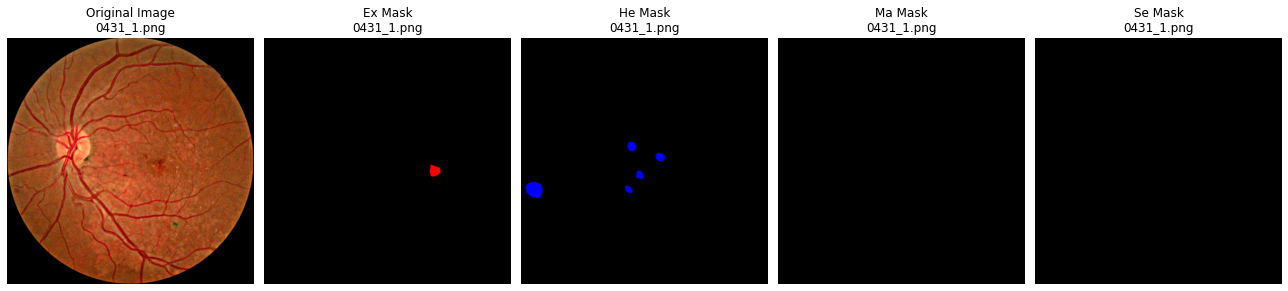

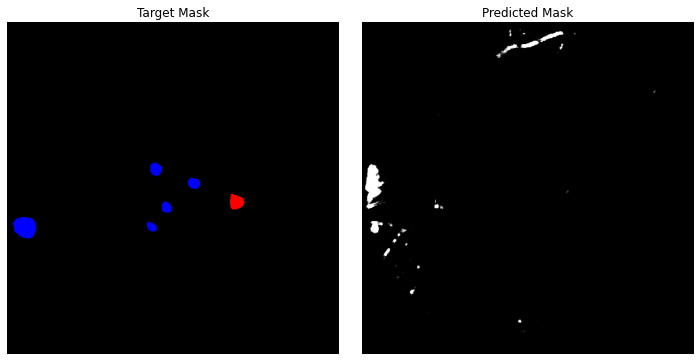

pred_shape : (512, 512)


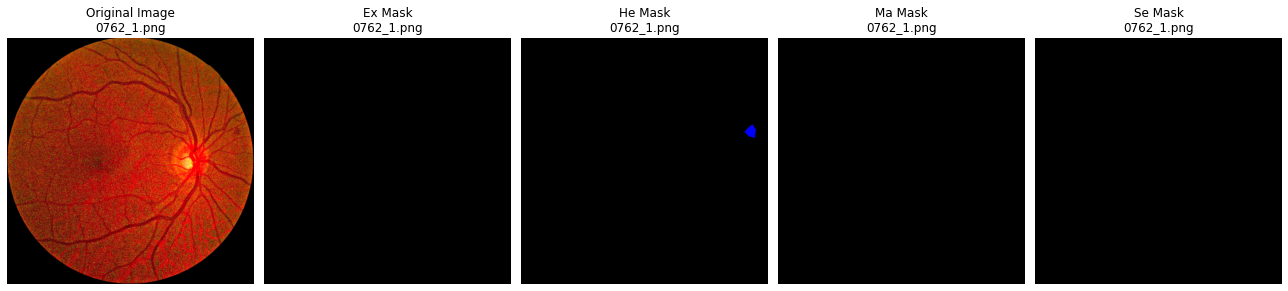

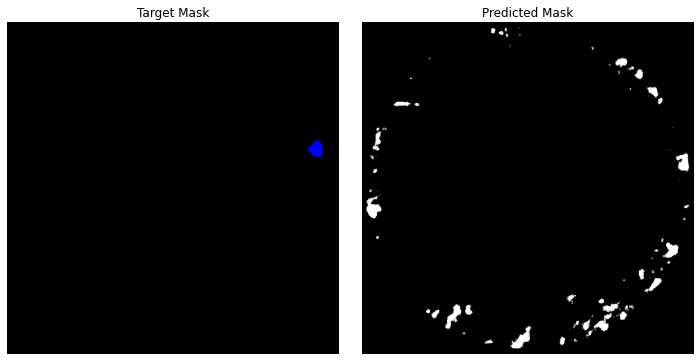

pred_shape : (512, 512)


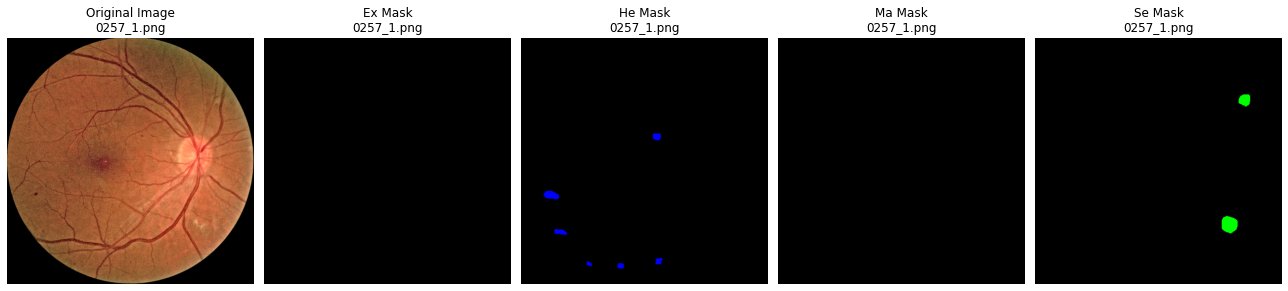

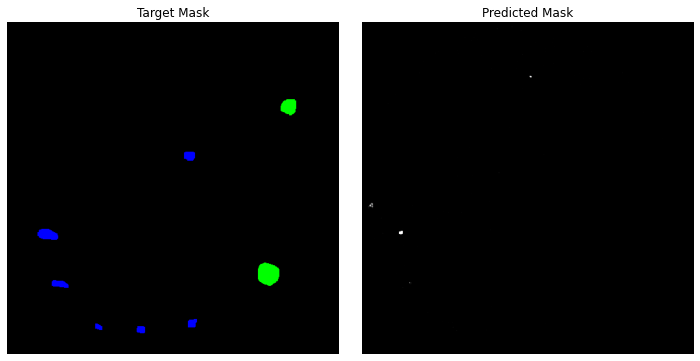

pred_shape : (512, 512)


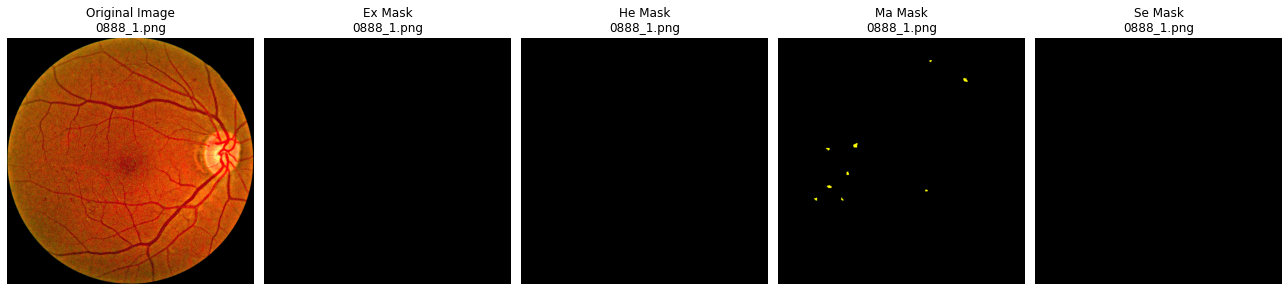

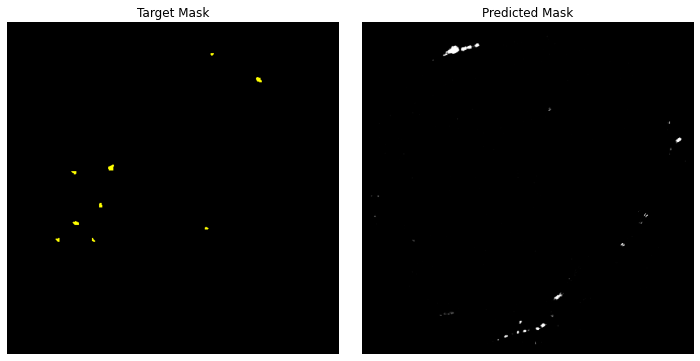

pred_shape : (512, 512)


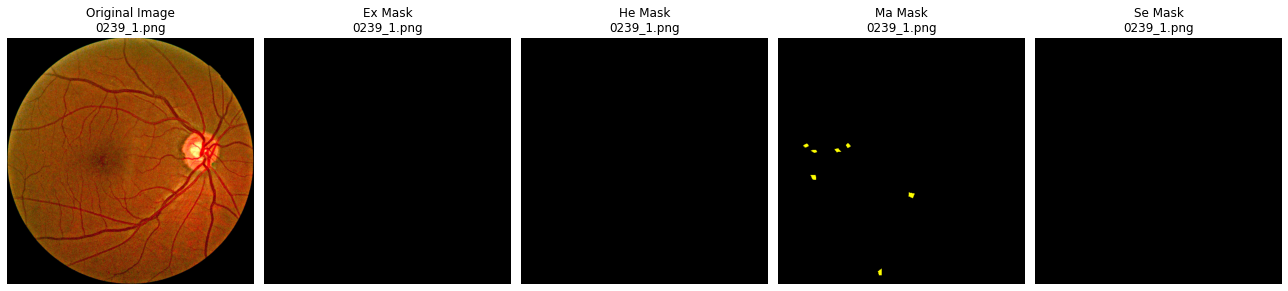

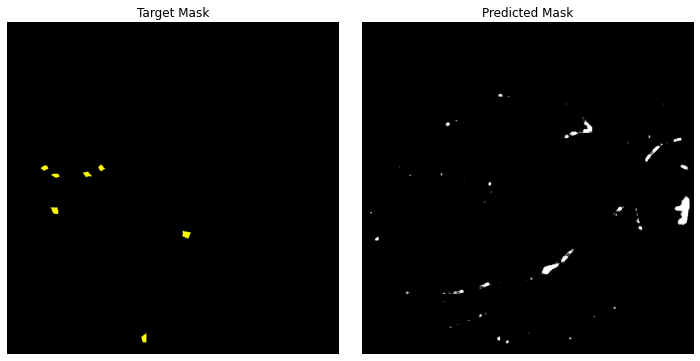

In [10]:
import numpy as np

# 시각화 및 평가
for image_index in range(len(load_images)):
    selected_image = load_images[image_index]

    # 랜덤하게 선택된 이미지 파일명
    image_filename = random_image_files[image_index]

    # 시각화할 원본 마스크 선택 및 리사이징
    selected_ex_mask = cv2.imread(os.path.join(mask_paths[0], image_filename), cv2.IMREAD_UNCHANGED)
    selected_ex_mask = cv2.resize(selected_ex_mask, (512, 512))

    selected_he_mask = cv2.imread(os.path.join(mask_paths[1], image_filename), cv2.IMREAD_UNCHANGED)
    selected_he_mask = cv2.resize(selected_he_mask, (512, 512))

    selected_ma_mask = cv2.imread(os.path.join(mask_paths[2], image_filename), cv2.IMREAD_UNCHANGED)
    selected_ma_mask = cv2.resize(selected_ma_mask, (512, 512))

    selected_se_mask = cv2.imread(os.path.join(mask_paths[3], image_filename), cv2.IMREAD_UNCHANGED)
    selected_se_mask = cv2.resize(selected_se_mask, (512, 512))

    # 시각화 함수 호출
    visualize_segmentation(selected_image, selected_ex_mask, selected_he_mask, selected_ma_mask, selected_se_mask, None, preds[1])
